In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import networkx as nx
from torch_geometric.utils import to_networkx, degree
import matplotlib.pyplot as plt

# Lade den Cora-Datensatz
dataset = Planetoid(root='dataset/cora', name='Cora')
data = dataset[0]

# Anzahl der Knoten
num_nodes = data.num_nodes

# Kantenliste als Tensor
edge_index = data.edge_index

# Erstelle einen NetworkX-Graphen aus den Daten
G = to_networkx(data, to_undirected=True)

# Berechne die verschiedenen Zentralitätsmaße
degree_centrality = degree(edge_index[0], num_nodes)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Normiere die Zentralitätsmaße
def normalize(tensor):
    return (tensor - tensor.mean()) / tensor.std()

degree_centrality = normalize(torch.tensor(list(degree_centrality), dtype=torch.float))
betweenness_centrality = normalize(torch.tensor([betweenness_centrality[i] for i in range(num_nodes)], dtype=torch.float))
closeness_centrality = normalize(torch.tensor([closeness_centrality[i] for i in range(num_nodes)], dtype=torch.float))
eigenvector_centrality = normalize(torch.tensor([eigenvector_centrality[i] for i in range(num_nodes)], dtype=torch.float))

# Kombiniere die Zentralitätsmaße
centrality_scores = torch.stack([degree_centrality, betweenness_centrality, closeness_centrality, eigenvector_centrality], dim=1)

print(centrality_scores)

tensor([[-0.1718, -0.2380,  0.1443, -0.2523],
        [-0.1718, -0.0824,  0.2976, -0.2521],
        [ 0.2107,  0.3455,  0.8877, -0.1848],
        ...,
        [-0.5543, -0.2381, -2.9192, -0.2571],
        [ 0.0195, -0.2324,  0.0156, -0.2541],
        [ 0.0195, -0.2139,  0.4041, -0.2444]])


Epoch 0, Train Loss: 1.2508, Eval Loss: 1.2189
Epoch 10, Train Loss: 1.0019, Eval Loss: 0.9997
Epoch 20, Train Loss: 0.9991, Eval Loss: 0.9990
Epoch 30, Train Loss: 0.9931, Eval Loss: 0.9939
Epoch 40, Train Loss: 0.9621, Eval Loss: 0.9521
Epoch 50, Train Loss: 0.9364, Eval Loss: 0.9302
Epoch 60, Train Loss: 0.9212, Eval Loss: 0.9068
Epoch 70, Train Loss: 0.9003, Eval Loss: 0.8957
Epoch 80, Train Loss: 0.8975, Eval Loss: 0.8943
Epoch 90, Train Loss: 0.8978, Eval Loss: 0.8876
Epoch 100, Train Loss: 0.8906, Eval Loss: 0.8857
Epoch 110, Train Loss: 0.8907, Eval Loss: 0.8863
Epoch 120, Train Loss: 0.8904, Eval Loss: 0.8859
Epoch 130, Train Loss: 0.8890, Eval Loss: 0.8842
Epoch 140, Train Loss: 0.8888, Eval Loss: 0.8861
Epoch 150, Train Loss: 0.8861, Eval Loss: 0.8828
Epoch 160, Train Loss: 0.8897, Eval Loss: 0.8829
Epoch 170, Train Loss: 0.8852, Eval Loss: 0.8828
Epoch 180, Train Loss: 0.8871, Eval Loss: 0.8815
Epoch 190, Train Loss: 0.8864, Eval Loss: 0.8822
Epoch 200, Train Loss: 0.8859, 

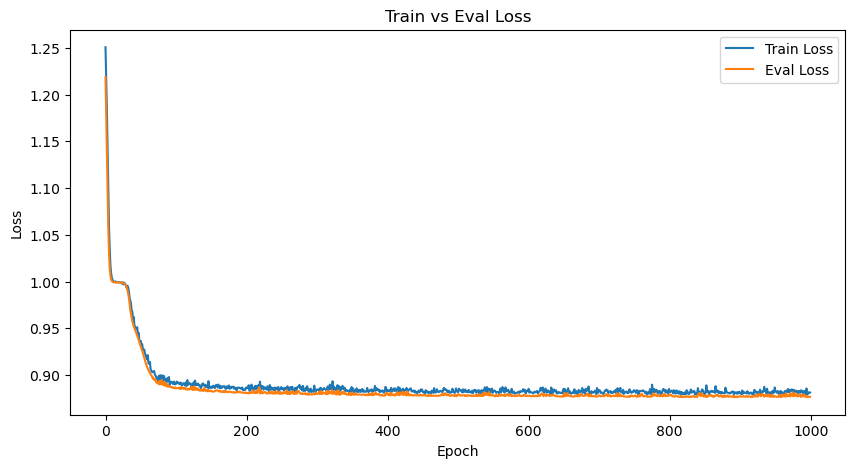

Tatsächliche Zentralitätswerte (normiert): [[-0.17175692 -0.23795836  0.14433227 -0.25227714]
 [-0.17175692 -0.08244419  0.29759762 -0.25205854]
 [ 0.21074118  0.34546676  0.8876848  -0.18482788]
 ...
 [-0.554255   -0.23809905 -2.9192321  -0.2571431 ]
 [ 0.01949213 -0.23238914  0.01564209 -0.25412074]
 [ 0.01949213 -0.21393137  0.4040617  -0.24439107]]
Vorhergesagte Relevanz: [[2.85444723e-04 6.11407915e-04 4.16448146e-01 1.25169766e-03]
 [4.69112565e-05 1.22188343e-04 1.34381413e-01 4.73136752e-05]
 [4.45898950e-05 1.15184295e-04 5.75931907e-01 2.63720372e-04]
 ...
 [3.68181209e-04 7.80398375e-04 8.55268445e-03 7.92586507e-05]
 [1.99250746e-04 4.48926934e-04 2.27124617e-01 2.76619307e-04]
 [3.68468580e-04 7.76234549e-04 3.90322059e-01 1.03994098e-03]]


In [9]:
# Einfache MLP zur Vorhersage der Knotenrelevanz
class NodeRelevanceNN(nn.Module):
    def __init__(self, num_node_features, hidden_dim=32, dropout=0.3):
        super(NodeRelevanceNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, 4)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return torch.sigmoid(x)  # Zentralitätswerte zwischen 0 und 1

model_relevance = NodeRelevanceNN(dataset.num_node_features)
optimizer_relevance = optim.Adam(model_relevance.parameters(), lr=0.01, weight_decay=5e-4)

# Listen zum Speichern der Verluste
train_losses = []
eval_losses = []

def train_relevance():
    model_relevance.train()
    optimizer_relevance.zero_grad()
    relevance_scores = model_relevance(data)
    # Berechne den MSE-Verlust zwischen den vorhergesagten Relevanzwerten und den tatsächlichen Zentralitätswerten
    loss = torch.mean((relevance_scores - centrality_scores) ** 2)
    loss.backward()
    optimizer_relevance.step()
    return loss.item()

def evaluate_relevance():
    model_relevance.eval()
    with torch.no_grad():
        relevance_scores = model_relevance(data)
        eval_loss = torch.mean((relevance_scores - centrality_scores) ** 2).item()
    return eval_loss

# Training für eine festgelegte Anzahl an Epochen
for epoch in range(1000):
    train_loss = train_relevance()
    eval_loss = evaluate_relevance()
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}')

# Plot der Trainings- und Evaluationsverluste
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Eval Loss')
plt.show()

# Überprüfung der Vorhersagen
model_relevance.eval()
with torch.no_grad():
    relevance_scores = model_relevance(data)
    print("Tatsächliche Zentralitätswerte (normiert):", centrality_scores.numpy())
    print("Vorhergesagte Relevanz:", relevance_scores.numpy())


In [19]:
import torch
import numpy as np

# Annahme: Die Paper-IDs sind im Dataset als Attribut `paper_id` vorhanden.
# Wenn nicht, musst du diese aus einer entsprechenden Datei oder einer anderen Quelle extrahieren.

# Beispiel Paper-IDs (hier durch Zufallszahlen ersetzt, bitte durch echte IDs ersetzen)
paper_ids = np.arange(num_nodes)  # Ersetze dies durch die echten Paper-IDs

# Top 20 Knoten basierend auf den berechneten Relevanzen (centrality_scores)
_, top_calculated_indices = torch.topk(torch.mean(centrality_scores, dim=1), 20)

# Top 20 Knoten basierend auf den vorhergesagten Relevanzen (relevance_scores)
_, top_predicted_indices = torch.topk(torch.mean(relevance_scores, dim=1), 20)

# Ausgabe der Top 20 berechneten Relevanzen
print("Top 20 berechnete Relevanzen:")
for idx in top_calculated_indices:
    paper_id = paper_ids[idx.item()]
    relevanz = torch.mean(centrality_scores[idx], dim=0).item()
    print(f"Paper ID: {paper_id}, Relevanz: {relevanz}")

# Ausgabe der Top 20 vorhergesagten Relevanzen
print("Top 20 vorhergesagte Relevanzen:")
for idx in top_predicted_indices:
    paper_id = paper_ids[idx.item()]
    relevanz = torch.mean(relevance_scores[idx], dim=0).item()
    print(f"Paper ID: {paper_id}, Relevanz: {relevanz}")


Top 20 berechnete Relevanzen:
Paper ID: 1358, Relevanz: 25.33700180053711
Paper ID: 1986, Relevanz: 8.030473709106445
Paper ID: 306, Relevanz: 7.20489501953125
Paper ID: 1701, Relevanz: 6.757259845733643
Paper ID: 2034, Relevanz: 5.218647480010986
Paper ID: 1072, Relevanz: 5.215932846069336
Paper ID: 1013, Relevanz: 4.087882995605469
Paper ID: 1810, Relevanz: 4.055517196655273
Paper ID: 88, Relevanz: 3.7595906257629395
Paper ID: 109, Relevanz: 3.3346426486968994
Paper ID: 2045, Relevanz: 2.927964448928833
Paper ID: 1169, Relevanz: 2.83323335647583
Paper ID: 1483, Relevanz: 2.7908377647399902
Paper ID: 1623, Relevanz: 2.631913900375366
Paper ID: 598, Relevanz: 2.6302599906921387
Paper ID: 733, Relevanz: 2.419799327850342
Paper ID: 1224, Relevanz: 2.2458815574645996
Paper ID: 1725, Relevanz: 2.1745972633361816
Paper ID: 1765, Relevanz: 2.137148380279541
Paper ID: 645, Relevanz: 2.105609893798828
Top 20 vorhergesagte Relevanzen:
Paper ID: 613, Relevanz: 0.5052000284194946
Paper ID: 1753, 

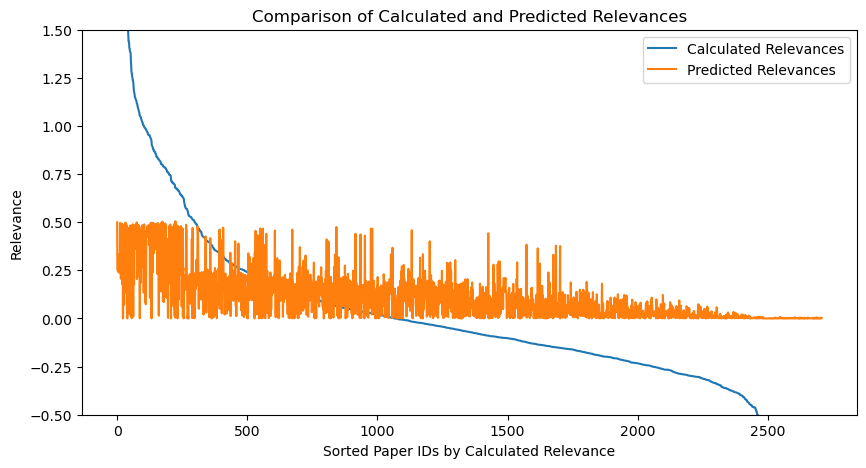

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Mittelwert der berechneten Relevanzen (centrality_scores) berechnen
calculated_relevance_mean = torch.mean(centrality_scores, dim=1)

# IDs der Paper sortieren basierend auf den berechneten Relevanzen
sorted_indices_by_calculated = torch.argsort(calculated_relevance_mean, descending=True)

# Berechnete und vorhergesagte Relevanzen extrahieren
sorted_calculated_relevances = calculated_relevance_mean[sorted_indices_by_calculated]
sorted_predicted_relevances = torch.mean(relevance_scores, dim=1)[sorted_indices_by_calculated]

# Plot der vorhergesagten Relevanzen basierend auf der sortierten ID-Liste der berechneten Relevanzen
plt.figure(figsize=(10, 5))
plt.plot(sorted_calculated_relevances.numpy(), label='Calculated Relevances')
plt.plot(sorted_predicted_relevances.numpy(), label='Predicted Relevances')
plt.xlabel('Sorted Paper IDs by Calculated Relevance')
plt.ylabel('Relevance')
plt.ylim(-0.5, 1.5)
plt.legend()
plt.title('Comparison of Calculated and Predicted Relevances')
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2485,) + inhomogeneous part.

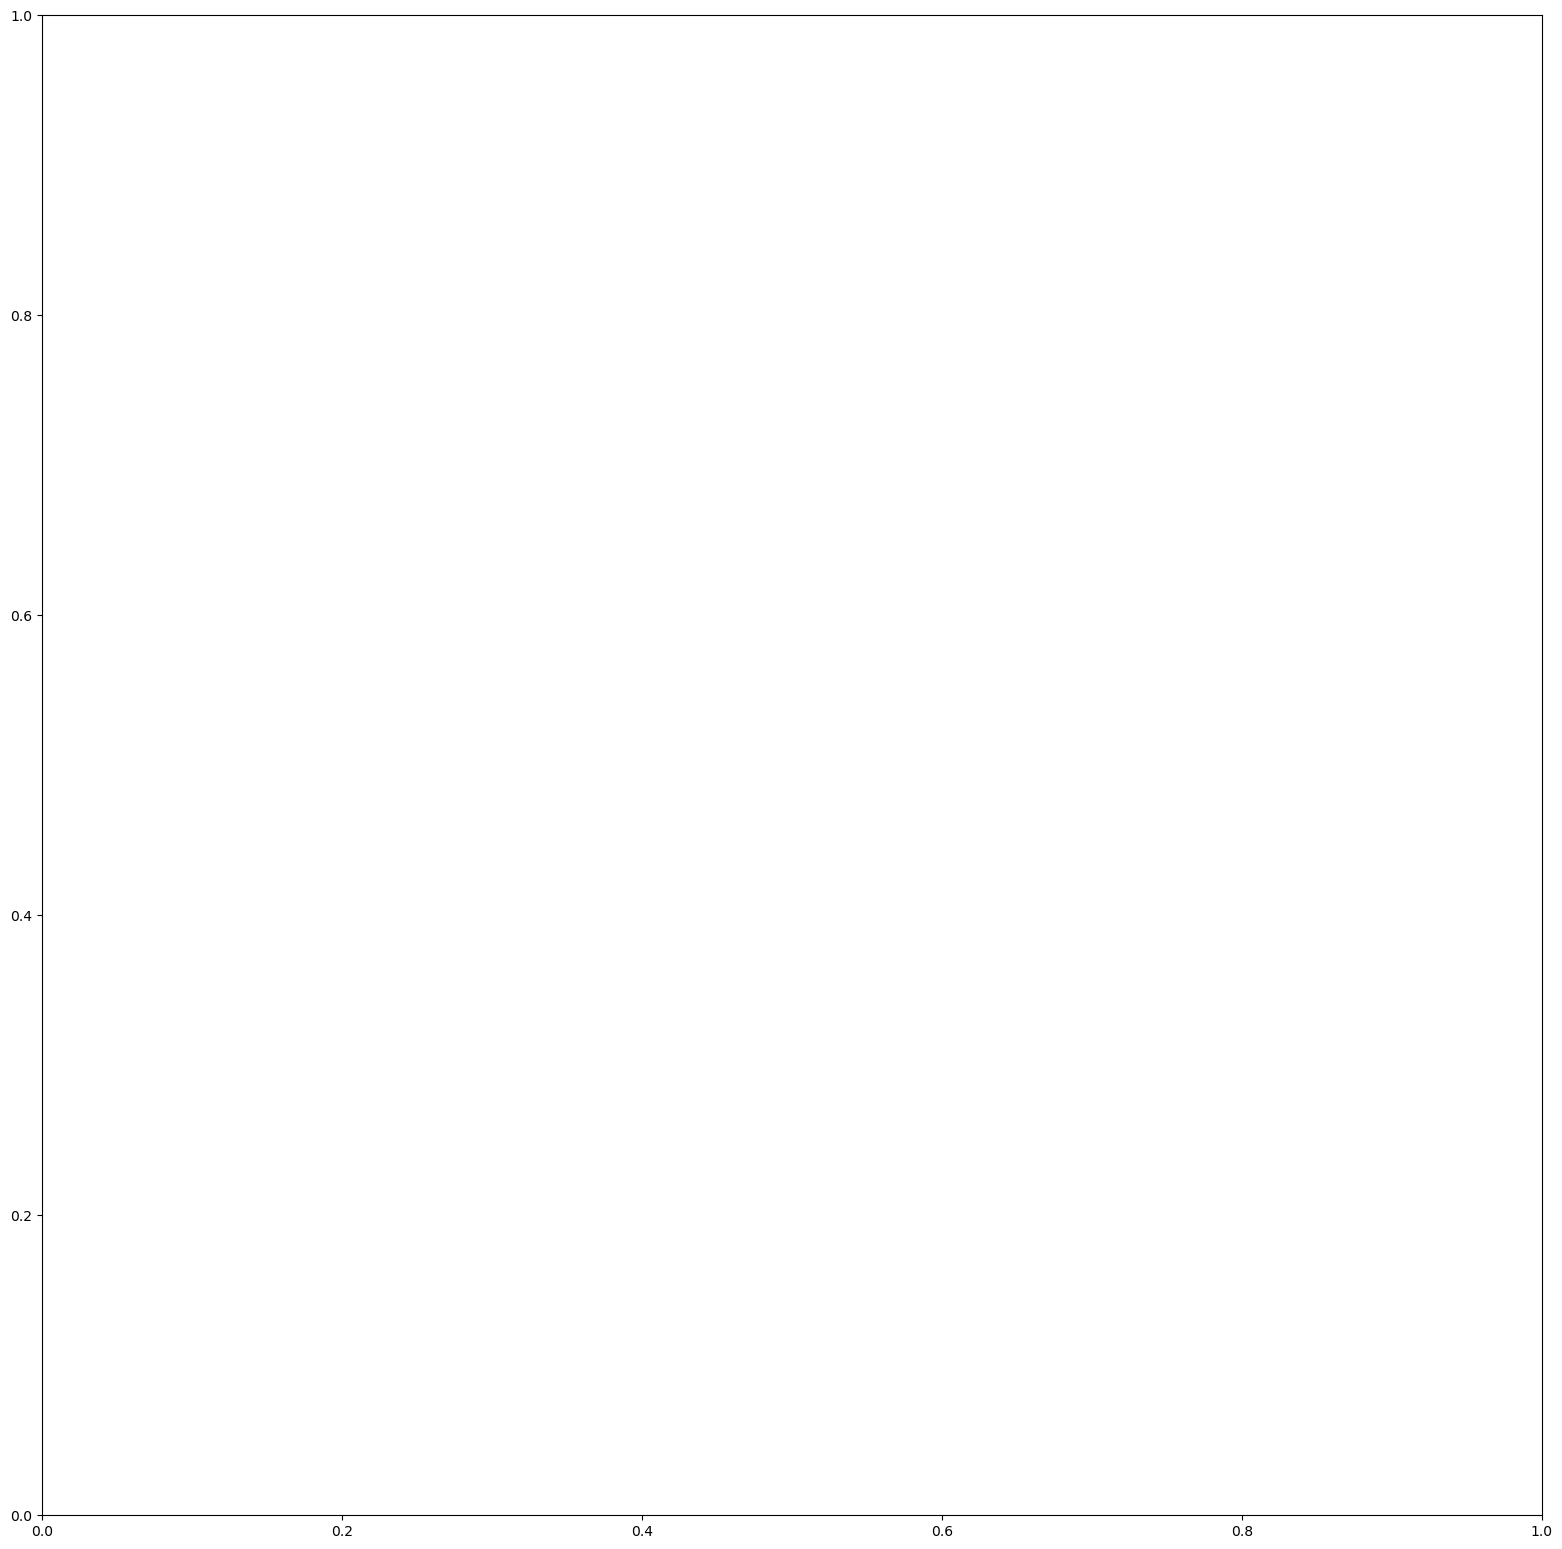

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Lade die .graphml Datei
graph = nx.read_graphml('graphs/cora.graphml')

# Extrahiere die Knoteninformationen
nodes = list(graph.nodes(data=True))

# Erstelle einen neuen leeren Graphen
star_graph = nx.Graph()

# Füge die Knoten aus dem ursprünglichen Graphen hinzu
for node in nodes:
    star_graph.add_node(node[0], **node[1])

# Wähle einen Knoten als zentralen Knoten (Hub) aus
hub_node = nodes[0][0]  # Nimm z.B. den ersten Knoten als Hub

# Verbinde den Hub mit allen anderen Knoten
for node in nodes:
    if node[0] != hub_node:
        star_graph.add_edge(hub_node, node[0])

# Zeichne den Star-Graphen
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(star_graph)  # Layout-Algorithmus für die Position der Knoten
nx.draw(star_graph, pos, with_labels=True, node_size=10, node_color='blue', edge_color='gray')
plt.title("Star Graph from .graphml file")
plt.show()

Epoch 0, Layout Train Loss: 14774.6738, Layout Eval Loss: 14164.3906
Epoch 10, Layout Train Loss: 11560.0430, Layout Eval Loss: 11138.0430
Epoch 20, Layout Train Loss: 10986.4619, Layout Eval Loss: 10944.9580
Epoch 30, Layout Train Loss: 10760.0273, Layout Eval Loss: 10673.1650
Epoch 40, Layout Train Loss: 10678.5303, Layout Eval Loss: 10618.2529
Epoch 50, Layout Train Loss: 10624.8301, Layout Eval Loss: 10632.8721
Epoch 60, Layout Train Loss: 10598.9258, Layout Eval Loss: 10595.8623
Epoch 70, Layout Train Loss: 10581.6855, Layout Eval Loss: 10566.8643
Epoch 80, Layout Train Loss: 10569.3818, Layout Eval Loss: 10570.8447
Epoch 90, Layout Train Loss: 10568.0684, Layout Eval Loss: 10585.4912
Epoch 100, Layout Train Loss: 10569.9248, Layout Eval Loss: 10596.6230
Epoch 110, Layout Train Loss: 10575.5361, Layout Eval Loss: 10569.5469
Epoch 120, Layout Train Loss: 10565.7861, Layout Eval Loss: 10574.7080
Epoch 130, Layout Train Loss: 10593.8574, Layout Eval Loss: 10567.3027
Epoch 140, Layout

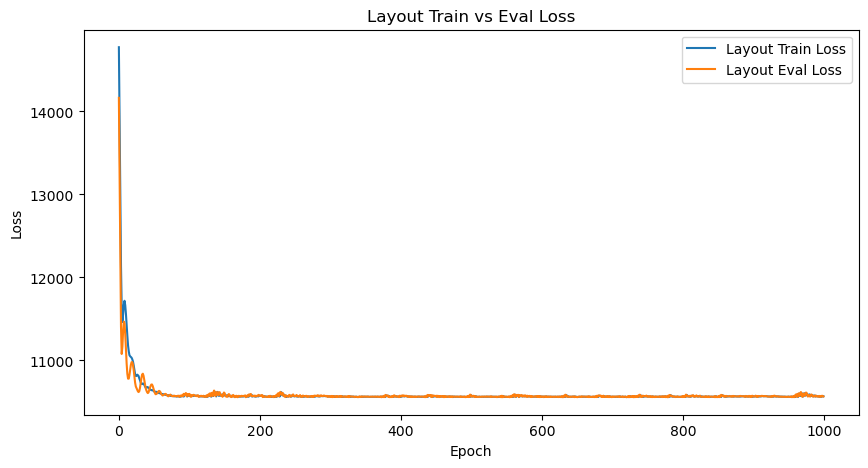

In [17]:
# Erweiterte Version des Layout-Modells mit zusätzlichen Schichten und Dropout
class GraphLayoutNN(nn.Module):
    def __init__(self, num_nodes, embedding_dim=2, hidden_dim=16, dropout=0.3):
        super(GraphLayoutNN, self).__init__()
        self.embeddings = nn.Embedding(num_nodes, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, embedding_dim)
        self.size_predictor = nn.Linear(embedding_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, edge_index):
        src = self.embeddings(edge_index[0])
        dst = self.embeddings(edge_index[1])
        src = self.relu(self.fc1(src))
        src = self.dropout(src)
        src = self.relu(self.fc2(src))
        src = self.dropout(src)
        src = self.fc3(src)
        dst = self.relu(self.fc1(dst))
        dst = self.dropout(dst)
        dst = self.relu(self.fc2(dst))
        dst = self.dropout(dst)
        dst = self.fc3(dst)
        return src, dst

    def get_node_positions(self):
        return self.embeddings.weight

    def get_node_sizes(self):
        positions = self.embeddings.weight
        sizes = torch.sigmoid(self.size_predictor(positions))
        return sizes


model_layout = GraphLayoutNN(num_nodes)
optimizer_layout = optim.Adam(model_layout.parameters(), lr=0.01)

# Funktion zur Berechnung der Verluste
def layout_loss_fn(src, dst, weights, relevance, alpha=1.0, beta=1.0, gamma=1.0):
    # Abstand zwischen verbundenen Knoten minimieren
    dist = torch.norm(src - dst, dim=1)
    # Bestrafe sich überschneidende Kanten
    overlap_penalty = torch.sum(torch.exp(-dist))
    # Berücksichtige Relevanz der Knoten, gemittelt über Quell- und Zielknoten
    relevance_src = relevance[edge_index[0]]
    relevance_dst = relevance[edge_index[1]]
    relevance_mean = (relevance_src + relevance_dst) / 2
    relevance_penalty = torch.sum(relevance_mean * dist)
    # Berücksichtige die Zentralität relevanter Knoten
    centrality_penalty_src = torch.sum((1 - relevance_src) * torch.norm(src, dim=1))
    centrality_penalty_dst = torch.sum((1 - relevance_dst) * torch.norm(dst, dim=1))
    centrality_penalty = centrality_penalty_src + centrality_penalty_dst
    return torch.mean(weights * dist) + alpha * overlap_penalty + beta * relevance_penalty + gamma * centrality_penalty

# Listen zum Speichern der Verluste
layout_train_losses = []
layout_eval_losses = []

def train_layout():
    model_layout.train()
    optimizer_layout.zero_grad()
    src, dst = model_layout(edge_index)
    relevance_scores = model_relevance(data)
    relevance_scores = torch.mean(relevance_scores, dim=1)  # Mittelwert der vier Zentralitätswerte
    loss = layout_loss_fn(src, dst, torch.ones(edge_index.shape[1]), relevance_scores)
    loss.backward()
    optimizer_layout.step()
    return loss.item()

def evaluate_layout():
    model_layout.eval()
    with torch.no_grad():
        src, dst = model_layout(edge_index)
        relevance_scores = model_relevance(data)
        relevance_scores = torch.mean(relevance_scores, dim=1)  # Mittelwert der vier Zentralitätswerte
        eval_loss = layout_loss_fn(src, dst, torch.ones(edge_index.shape[1]), relevance_scores).item()
    return eval_loss

# Training für das Layout-Modell
for epoch in range(1000):
    train_loss = train_layout()
    eval_loss = evaluate_layout()
    layout_train_losses.append(train_loss)
    layout_eval_losses.append(eval_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Layout Train Loss: {train_loss:.4f}, Layout Eval Loss: {eval_loss:.4f}')

# Plot der Trainings- und Evaluationsverluste
plt.figure(figsize=(10, 5))
plt.plot(layout_train_losses, label='Layout Train Loss')
plt.plot(layout_eval_losses, label='Layout Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Layout Train vs Eval Loss')
plt.show()

# Visualisierung der Knotenpositionen und -größen
node_positions = model_layout.get_node_positions().detach().numpy()
node_sizes = model_layout.get_node_sizes().detach().numpy()

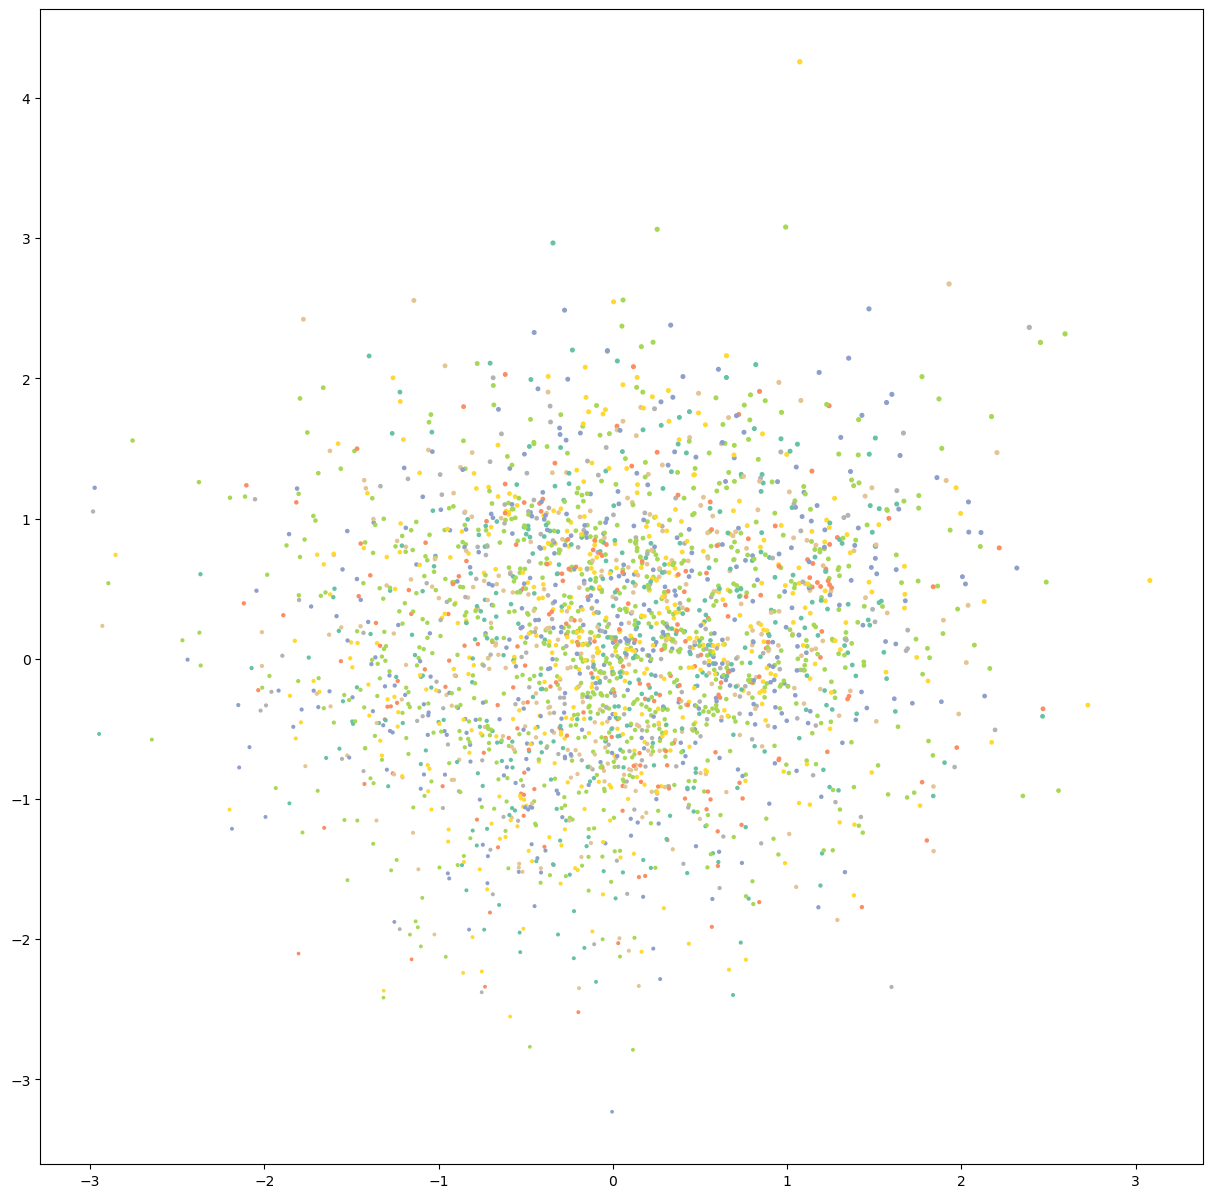

In [14]:
plt.figure(figsize=(15, 15))
plt.scatter(node_positions[:, 0], node_positions[:, 1], s=node_sizes * 10, c=data.y.numpy(), cmap="Set2")
plt.show()
